<a href="https://colab.research.google.com/github/Valeron01/Anime-GAN/blob/master/Anime_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

import tensorflow as tf

import sys
sys.path.append('/content/drive/My Drive')

import nn_utils as ut
import numpy as np
import cv2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Add, Input, Activation, BatchNormalization, Conv2DTranspose, Dense, BatchNormalization, Reshape, Flatten, LeakyReLU, Dropout, ReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from google.colab.patches import cv2_imshow
import time

In [2]:
!cp "/content/drive/My Drive/animefacedataset.zip" /content

In [3]:
!unzip animefacedataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: images/62765_2019.jpg   
  inflating: images/62766_2019.jpg   
  inflating: images/62767_2019.jpg   
  inflating: images/62768_2019.jpg   
  inflating: images/62769_2019.jpg   
  inflating: images/6276_2003.jpg    
  inflating: images/62770_2019.jpg   
  inflating: images/62771_2019.jpg   
  inflating: images/62772_2019.jpg   
  inflating: images/62773_2019.jpg   
  inflating: images/62774_2019.jpg   
  inflating: images/62775_2019.jpg   
  inflating: images/62776_2019.jpg   
  inflating: images/62777_2019.jpg   
  inflating: images/62778_2019.jpg   
  inflating: images/62779_2019.jpg   
  inflating: images/6277_2003.jpg    
  inflating: images/62780_2019.jpg   
  inflating: images/62781_2019.jpg   
  inflating: images/62782_2019.jpg   
  inflating: images/62783_2019.jpg   
  inflating: images/62784_2019.jpg   
  inflating: images/62785_2019.jpg   
  inflating: images/62786_2019.jpg   
  inflating: images/

In [25]:
images = ut.loadAllImages('images', w = -1, h = -1)

good_images = []
for i, v in enumerate(images):
  if v.shape[0] >= 64:
    good_images.append(cv2.resize(v, (64, 64)))
    
images = np.float32(good_images)
images = (images - 127.5) / 127.5

0
(63565,)


In [ ]:
images = ut.loadAllImages('images', w = 96, h = 96)
images = np.float32(images)
images = (images - 127.5) / 127.5

In [27]:
def get_random_samples(batch_size=16):
  return images[np.random.randint(0, len(images), batch_size)]

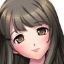

In [30]:
cv2_imshow(get_random_samples()[0] * 127.5 + 127.5)

In [31]:
def get_residual_block(units, prev):
  ret = Conv2DTranspose(units, (3, 3), padding='same')(prev)
  #ret = BatchNormalization()(ret)
  a = ReLU()(ret)
  c = Conv2DTranspose(units, (3, 3), padding='same')(a)
  #c = BatchNormalization()(c)
  ret = Add()([prev, c])
  return ret

In [32]:
def get_upsamling_block(units, prev):
  c = Conv2DTranspose(units, 3, padding='same', strides=2)(prev)
  #c = BatchNormalization()(c)
  r = ReLU()(c)
  return r

In [33]:
def build_generator():
  in_l = Input(shape=(100,))

  d = Dense(64 * 16 * 16)(in_l)
  d = ReLU()(d)

  d = Reshape((16, 16, 64))(d)

  r = get_residual_block(64, d)

  r = get_residual_block(64, r)
  r = get_residual_block(64, r)
  r = get_residual_block(64, r)
  r = get_residual_block(64, r)
  r = get_residual_block(64, r)
  r = get_residual_block(64, r)
  r = get_residual_block(64, r)
  r = get_residual_block(64, r)
  r = get_residual_block(64, r)
  r = get_residual_block(64, r)
  r = get_residual_block(64, r)
  r = get_residual_block(64, r)

  i = Add()([r, d])

  u = get_upsamling_block(256, i)
  u = get_upsamling_block(256, u)

  o = Conv2DTranspose(3, 5, padding = 'same', activation='tanh')(u)


  model = Model(inputs=in_l, outputs=o, name='Generator')

  return model

In [34]:
def get_residual_block_v2(units, prev):
  c = Conv2D(units, 3, padding='same')(prev)
  l = LeakyReLU()(c)
  c = Conv2D(units, 3, padding='same')(l)
  a = Add()([c, prev])
  l = LeakyReLU()(a)
  return l

In [35]:
def build_discriminator():
  in_l = Input(shape=(64, 64, 3))

  c_1 = Conv2D(32, 4, strides=2, padding='same')(in_l)
  l = LeakyReLU()(c_1)

  r = get_residual_block_v2(32, l)
  r = get_residual_block_v2(32, r)

  r  = Conv2D(64, 4, strides=2, padding='same')(r)
  r = LeakyReLU()(r)

  r = get_residual_block_v2(64, r)
  r = get_residual_block_v2(64, r)

  r  = Conv2D(128, 4, strides=2, padding='same')(r)
  r = LeakyReLU()(r)

  ##########

  r = get_residual_block_v2(128, r)
  r = get_residual_block_v2(128, r)

  r  = Conv2D(256, 3, strides=2, padding='same')(r)
  r = LeakyReLU()(r)


  r = get_residual_block_v2(256, r)
  r = get_residual_block_v2(256, r)

  r  = Conv2D(512, 3, strides=2, padding='same')(r)
  r = LeakyReLU()(r)

  r = Flatten()(r)

  d = Dense(1, activation='sigmoid')(r)

  m = Model(inputs=in_l, outputs=d)

  opt = Adam(lr=0.0001, beta_1=0.5)
  m.compile(loss='binary_crossentropy', optimizer=opt)


  return m

In [36]:
def build_gan(gen, disc):
  disc.trainable = False
  m = Sequential()
  m.add(gen)
  m.add(disc)

  opt = Adam(lr=0.0001, beta_1=0.5)
  m.compile(loss='binary_crossentropy', optimizer=opt)
  return m

In [ ]:
gen = build_generator()
disc = build_discriminator()
gen.summary()
print("##########################################################")
disc.summary()
gan = build_gan(gen, disc)

In [ ]:
gan.summary()

In [38]:
def train_step(batch_size=16):
  real = get_random_samples(batch_size)

  noise = np.random.normal(size=(batch_size, 100))
  fake = gen(noise)

  zeros = np.zeros(batch_size)
  ones = np.ones(batch_size)


  disc_loss_1 = disc.train_on_batch(fake, zeros)
  disc_loss = disc.train_on_batch(real, ones)

  gen_loss = gan.train_on_batch(noise, ones)
  

  return (disc_loss, disc_loss_1, gen_loss)

In [39]:
def save_results(model):
  noise = np.random.normal(size=(25, 100))
  ims = model.predict(noise)
  ims = ims * 127.5 + 127.5
  ret = np.zeros(shape=(320, 320, 3))
  k = 0
  for i in range(5):
    for j in range(5):
      ret[i*64:i*64+64, j*64:j*64+64] = ims[k]
      k += 1
  return ret

In [40]:
def train(epochs=1, batch_size=16):
  for i in range(epochs):
    start = time.time()
    d_l, d_l_1, g_l = train_step(batch_size)
    end = time.time()
    if i % 100 == 0:
      gen.save('drive/My Drive/anime_generator_v8.h5')
      disc.trainable = True
      disc.save('drive/My Drive/anime_discriminator_v8.h5')
      disc.trainable = False
    if i % 50 == 0:
      print(f'Batch {i + 1} / {epochs}, disc_loss: {d_l}, disc_loss1: {d_l_1}, gen_loss: {g_l}, time: {end-start}')
      n = np.random.normal(size=(1, 100))
      f = gen.predict(n)[0]
      f = cv2.resize(f, (128, 128), interpolation=cv2.INTER_NEAREST)
      cv2.imwrite('batch.png', save_results(gen))


In [43]:
disc.optimizer.learning_rate.assign(3e-5)
gan.optimizer.learning_rate.assign(3e-5)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=3e-05>

In [ ]:
train(10000, batch_size=128)

Batch 1 / 10000, disc_loss: 0.10202360153198242, disc_loss1: 0.19790337979793549, gen_loss: 4.629951477050781, time: 0.3487098217010498
Batch 51 / 10000, disc_loss: 0.07466563582420349, disc_loss1: 0.08893318474292755, gen_loss: 5.292317867279053, time: 0.3393831253051758
Batch 101 / 10000, disc_loss: 0.06153908744454384, disc_loss1: 0.09266752004623413, gen_loss: 6.302574634552002, time: 0.3360450267791748
Batch 151 / 10000, disc_loss: 0.0964394360780716, disc_loss1: 0.08325134962797165, gen_loss: 6.167316436767578, time: 0.3325178623199463
Batch 201 / 10000, disc_loss: 0.08657480031251907, disc_loss1: 0.1297030746936798, gen_loss: 6.4217424392700195, time: 0.33312153816223145
Batch 251 / 10000, disc_loss: 0.10342197120189667, disc_loss1: 0.0711619108915329, gen_loss: 6.649590969085693, time: 0.33429646492004395
Batch 301 / 10000, disc_loss: 0.07457093894481659, disc_loss1: 0.11878734081983566, gen_loss: 6.667832851409912, time: 0.3346383571624756
Batch 351 / 10000, disc_loss: 0.13814

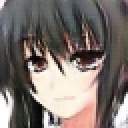

In [ ]:
n = np.random.normal(size=(1, 100))
f = gen.predict(n)[0]
f = cv2.resize(f, (128, 128), interpolation=cv2.INTER_NEAREST)
cv2_imshow(f * 127.5 + 127.5)

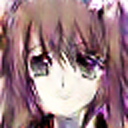

In [ ]:
f = gen.predict(n)[0]
f = cv2.resize(f, (128, 128), interpolation=cv2.INTER_CUBIC)
cv2_imshow(f * 127.5 + 127.5)

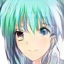

In [ ]:
f = gen.predict(n)[0]
f = cv2.resize(f, (64, 64), interpolation=cv2.INTER_CUBIC)
cv2_imshow(f * 127.5 + 127.5)

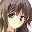

In [ ]:
cv2_imshow(f * 127.5 + 127.5)

In [ ]:
gen.save('anime_gen_Noice5.h5')
disc.save('anime_disc_Noice5.h5')

In [ ]:
gen = tf.keras.models.load_model('anime_gen_Noice5.h5')
disc = tf.keras.models.load_model('anime_disc_Noice5.h5')

In [ ]:
fr = np.random.normal(size=(10,))
to = np.random.normal(size=(10,))

def arange(s, e, steps):
  ret = np.zeros((steps,) + s.shape)
  
  delta = (e - s) / steps
  for i in range(steps):
    ret[i] = s + delta * i

  return ret

a = arange(fr, to, 100)

In [ ]:
fake_ims = gen.predict(np.random.normal(size=(10000, 100)))

In [ ]:
predictions = disc.predict(fake_ims)

In [ ]:
i = np.argmin(predictions)
print(i)
print(predictions[i])

327
[8.3469114e-14]


In [ ]:
acc = tf.keras.metrics.binary_accuracy(tf.zeros_like(predictions), predictions).numpy()

In [ ]:
np.count_nonzero(acc)

NameError: ignored

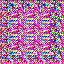

In [ ]:
cv2_imshow(fake_ims[7745] * 127.5 + 127.5)

In [ ]:
predictions

array([[0.0191663 ],
       [0.04411966],
       [0.0506802 ],
       ...,
       [0.01985994],
       [0.07549419],
       [0.00522235]], dtype=float32)

In [ ]:
gen = tf.keras.models.load_model('drive/My Drive/anime_generator_v5.h5')
disc = tf.keras.models.load_model('drive/My Drive/anime_discriminator_v5.h5')

In [ ]:
n

array([[-1.51493888,  1.18935531, -0.49500658,  1.68341662,  1.45486417,
        -1.32634059, -1.63928894,  0.33562166,  0.65451385,  0.23797742,
        -2.9719301 , -0.44887682,  1.95955084, -0.204819  ,  0.98065604,
        -0.291756  , -0.13614286, -0.95799494,  1.26978087,  1.29383237,
         0.54153035,  0.82124221,  0.39798113, -0.1293979 , -0.26349407,
         0.30377509,  0.04547751,  0.84143531,  0.47789479,  1.87140213,
         0.15196161,  0.16268972, -0.08254734, -0.09750286, -1.04536405,
         1.5264992 ,  0.22722155, -0.56609969,  1.30868814, -1.21827103,
        -0.25161436, -0.46428727,  0.01688903, -1.53778785,  2.0059006 ,
        -0.69250598,  0.34137275,  0.50034021, -2.30435404, -0.18979345,
        -1.66339715, -0.53194536,  0.45414245, -0.61115538, -0.5396266 ,
         0.40115236,  0.13520949,  0.04499437,  1.84446034, -0.86263353,
        -0.137942  ,  0.0787324 , -0.71778495, -1.88037268,  0.61823749,
        -0.34459737, -0.47141729,  2.17171699,  0.4

In [ ]:
gen.save('drive/My Drive/anime_generator_vBEST.h5')
disc.save('drive/My Drive/anime_discriminator_vBEST.h5')